## Import libraries

In [2]:
from geo_utils import *

## Download OSM data

In [33]:
# Specify country code so all output file will be labeled correctly
country_alpha_3_code = 'ZMB'

# Specify UTM zone EPSG code for this country, so that projection operation in this notebook knows the target CRS
country_utm_epsg = 'epsg:32735' # Africa Albers equal area conic projection

# Provide country name as input, the data will be downloaded as a PBF file 

# The filepath to that PBF file will be returned and saved in variable "fp"
fp = get_osm_data_as_pbf("Zambia")

# We then pass the filepath to OSM object constructer to initialize the object
osm = pyrosm.OSM(fp)

## Load OSM Features

### 1. Transportation Network

In [4]:
driving_network = osm.get_network(network_type="driving")

*Network type choices:*

- walking
- cycling
- driving
- driving+service (includes also public service vehicles)
- all (includes all modes listed above)

In [5]:
driving_network.head(5)

,access,area,bicycle,bridge,cycleway,foot,highway,junction,lanes,lit,...,tracktype,tunnel,width,id,timestamp,version,tags,osm_type,geometry,length
0,None,None,None,None,None,None,unclassified,None,None,None,...,None,None,None,10423486,1548773450,21,None,way,"MULTILINESTRING ((25.85570 -17.87637, 25.85317...",1760.0
1,None,None,None,None,None,None,residential,None,None,None,...,None,None,None,10423488,1548773450,9,None,way,"MULTILINESTRING ((25.84709 -17.88085, 25.84697...",730.0
2,None,None,None,None,None,None,trunk,None,None,None,...,None,None,None,10424051,1644214027,36,"{""source"":""GPS""}",way,"MULTILINESTRING ((25.27659 -17.77594, 25.27605...",893.0
3,None,None,None,None,None,None,secondary,None,None,None,...,None,None,None,21486874,1640697241,27,None,way,"MULTILINESTRING ((30.09093 -9.04848, 30.08510 ...",27775.0
4,None,None,None,None,None,None,secondary,None,None,None,...,None,None,None,21511080,1640157618,32,None,way,"MULTILINESTRING ((30.12411 -9.36392, 30.12521 ...",31746.0


<br>
By default, the driving network data will contain many fields that are derived and expanded from the raw OSM data. However, most of the fields will have missing values for majority of the roads. 
<br>
<br>

In [18]:
(driving_network.notnull().mean().sort_values(ascending=False)*100).reset_index().rename(columns={'index':'field',0:'non-null rate'})

,field,non-null rate
0,length,100.000000
1,geometry,100.000000
2,osm_type,100.000000
3,highway,100.000000
4,version,100.000000
5,timestamp,100.000000
6,id,100.000000
7,surface,20.106092
8,tags,7.978513
9,ref,4.242194


<br>
Since our goal is to use OSM data in predicting settlements, we want the fields to have full coverage over the country and similar availability in urban and rural areas alike. Thus, we will not use fields that are only partial available. We can do this by dropping all columns with missing values.
<br>
<br>

In [19]:
driving_network = driving_network.dropna(axis=1)

<br>
<br>
Walking + cycling is not a preset filter, but we can create such a layer by 1) identifying which roads are uniquely for cycling; 2) merging the uniquely for cycling roads with the walking roads. This way, duplicates are avoided, which is desirable when two datasets overlay a lot.
<br>
<br>

In [21]:
walking_network = osm.get_network(network_type="walking").dropna(axis=1)

cycling_network = osm.get_network(network_type="cycling").dropna(axis=1)

just_cycling_no_walking_network = get_not_contained_part(cycling_network, walking_network)

print(len(just_cycling_no_walking_network), 'roads are just for cycling not for walking.')

walking_network = pd.concat([walking_network, just_cycling_no_walking_network], ignore_index=True)

6 roads are just for cycling not for walking.


<br>
Similarly, we can combine walking and driving network this way and mark what is the fastest modality on each road.
<br>
<br>

In [27]:
just_walking_no_driving =  get_not_contained_part(walking_network, driving_network)

print('Out of',len(walking_network),'walkable roads,', len(just_walking_no_driving), 'roads are just for walking not for driving.')

Out of 342546 walkable roads, 208438 roads are just for walking not for driving.


In [28]:
just_walking_no_driving['fastest_modality'] = 'walking'

driving_network['fastest_modality'] = 'driving'

road_network = pd.concat([just_walking_no_driving, driving_network], ignore_index = True)

<br>
Save the combined road network to Feather file format. Developed under Apache Arrow project, Feather file is smaller in size on disk, faster to read and write. Only limitation is that mainstream GIS software will not be able to read it directly. However, we are mainly using the dataset in Python/R analytical environment, so it will do fine.
<br>
<br>

In [36]:
road_network.to_feather('./data/'+country_alpha_3_code+'_osm_road_network_v20220418.feather')

### 2. Point of Interest (POI)

Presence of POIs are usually strong predictor of the existence of settlements nearby. While POI data on OSM may have very uneven coverage depending on region and level of contribution on the ground, it is worth investigating if they have predictive power when they exist.

In [ ]:
# Combine entries that have amenity tag and/or shop tag set to True to get more POIs
pois = osm.get_pois(custom_filter={'amenity': True, "shop": True})
# When both tags exist, use amenity first and use shop tag when amenity tag is not available
pois["poi_type"] = pois["amenity"].fillna(pois["shop"])

pois = pois.dropna(axis=1)


POIs have different shapes, using centroid operation to represent each POI as a point

In [ ]:
pois['geometry_centroid'] = pois.geometry.to_crs(country_utm_epsg).centroid.to_crs(pois.crs)
pois = pois.set_geometry('geometry_centroid', drop=True)

In [46]:
pois.to_feather('./data/ZMB_osm_pois_v20220418.feather')

### 3. Land Use

In [47]:
landuse = osm.get_landuse().dropna(axis=1)

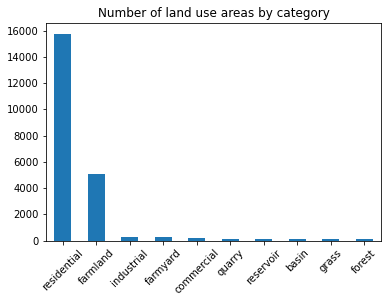

In [59]:
landuse.landuse.value_counts().head(10).plot(kind='bar')
plt.xticks(rotation = 45)
_ = plt.title('Number of land use areas by category')

In [49]:
landuse.to_feather('./data/ZMB_osm_landuse_v20220418.feather')

### 4. Buildings

OSM also provide building level data, some of the buildings even have tags showing their use, material, and other information. However, the same problem of uneven level of missing values affect this source of data, making it more biased for settlement prediction.

In [50]:
buildings = osm.get_buildings().dropna(axis=1)

buildings['geom_centroid'] = buildings.geometry.to_crs(country_utm_epsg).centroid.to_crs(buildings.crs)
buildings = buildings.set_geometry('geom_centroid')

buildings.to_feather('./data/ZMB_osm_buildings_v20220418.feather')